<a href="https://colab.research.google.com/github/kyuenjpl/ARSET_XCO2/blob/main/test_pydap_session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective:
- Using PYDAP library to create session and retrieve multiple files from openDAP server
- Plot and visualize the retreived datasets
- Required Earthdata Account Credentials:
  * you can create free acocunt on: 

  https://urs.earthdata.nasa.gov/oauth/authorize?response_type=code&client_id=OLpAZlE4HqIOMr0TYqg7UQ&redirect_uri=https%3A%2F%2Fd53njncz5taqi.cloudfront.net%2Furs_callback&state=https%3A%2F%2Fsearch.earthdata.nasa.gov%2Fsearch%3Fee%3Dprod


## Instructions to run the script:
1. Runtime(top section) -> Run all
  * Downloads the required packages to run the script if you are running script for first time
2. INPUT prompts -> Provide year, month, version
  * (NOTE: opendap has current 10vr. only)
3. INPUT prompts for credentials -> Earthdata Login credentials (Username and password)
4. INPUT prompt: Location/region for data visuals

### Install **libraries/packages** to run this script

In [ ]:
!pip install jupyter \
pytest \
poetry \
numpy \
pandas \
pydap \
basemap==1.3.6 \
matplotlib \
plotly==5.13.1 \
netCDF4==1.6.3 \
bs4 \
geopy \
pyarrow \
lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.2/859.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 

In [ ]:
## libraries for data access and pre-processing
## preprocessing: retireve data from netCDF and convert to pandas columns
import netCDF4 # packages to open 'netcdf' file
import numpy as np # numpy and pandas packages to pre-process the dataset
import pandas as pd

# for visualization 
import matplotlib.pyplot as plt # to create plots and graphs
from mpl_toolkits.basemap import Basemap # to create geo-spatial map, requires dependencies installation
import plotly.express as px
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.collections import PatchCollection
import time
import matplotlib

# to load webcontent and retrieve data from link
from IPython.display import display, HTML
from IPython import display
from datetime import datetime

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## CLEANING
import gc
import sys

In [ ]:
## GEOPY package to locate the region
from geopy.geocoders import Nominatim
import geopy

In [ ]:
# WEB SCRAP the contents
import re
# to grab data from entire year, month
from bs4 import BeautifulSoup # 
from IPython.display import Image

In [ ]:
# Data ACCESS from OPENDAD source
## Libraries
from urllib import request, parse
import getpass
import netrc
import os
import requests
import matplotlib.image as mpimg
import os
import time
from netCDF4 import Dataset

# pydap library to open session
from pydap import client
from pydap.cas.urs import setup_session
from pydap.client import open_url

import json

## Get Session
- To get Access to openDAP server; we create session TOKEN and make requests
### Future work:
- create asynchronous functions for making multiple requests without waiting time 

In [ ]:
def get_session(url, file_name):
    """
    Creating a session with url and filename in openDap for data retrieval
    https://oco2.gesdisc.eosdis.nasa.gov/opendap/
    """
    try:
        login_credentials= 'uat.urs.earthdata.nasa.gov'
        username, _, password = netrc.netrc().authenticators(login_credentials)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('\n*******************************************\n')
        print('Please provide your Earthdata Login credentials to allow data access\n')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (url))
        print('\n')
        username = input('Username: ')
        password = getpass.getpass()
        print('\n*******************************************\n')
        
    # pydap session
    session = setup_session(username, password, check_url= url + file_name)
    
    # using the session to get access the data
    return session

### NOTE:
1. First, retrieve the contents from the specified year, version of files
2. Get the first file from the list

### Data Source:
- For this tutorial, we will download files from OpenDAP server
- main_url= https://oco2.gesdisc.eosdis.nasa.gov/opendap

#### OCO format
- `OCO2_L2_Lite_FP` -> 10.vr, 11.vr
- `OCO3_L2_Lite_FP` -> 10.vr

**********************************************************

# INPUT:
- Information:
    * year
    * month
    * Version of the file
    
- Data format on the server: `netCDF` file format on OpenDap Server

**********************************************************
* EXAMPLE:
    - /OCO3_L2_Lite_FP.10.4r
    - /2020
    - <b>FORMAT</b>: /oco3_LtCO2_200106_B10400Br_220317235330s.nc4.html

In [ ]:
# display.Image(filename="../screenshots/opendap_server.png")

Image(url="https://github.com/sagarlimbu0/oco2-oco3_data_access_visualization/blob/main/screenshots/opendap_server.png")

In [ ]:
from google.colab.patches import cv2_imshow 

## Get access to `OpenDAP` server 
- webscrap the entire files for the specified year
- Make iterative requests to get files from the server and pre-process the data to visualize

In [ ]:
%%time
print("OCO3 currently has -> 10 vr.\n")
## INPUT for specified year, version of file
year= input("Enter the Year: ")
month= input("Enter the Month: ")
ver_= input("Enter the version: ")

## FORMAT the filenames by VERSION and YEAR
## RETRIEVE all filenames for the YEAR using webscraping 
## OCO3
lite_file= '/OCO3_L2_Lite_FP.'+ str(ver_)+ '.4r' +'/'+ year 

########################################################################
# GET THE files from OpenDap source. Open the netcdf file and store in dataframe
# Beautiful soup to retrieve all data for the MONTH
# EXAMPLE: in this test, we will use SINGLE file of the month
########################################################################

main_url='https://oco2.gesdisc.eosdis.nasa.gov/opendap'
content= '/contents.html'

s= requests.get(main_url + lite_file + content)

## Scrap the content by specified URL
## Get the entire filenames of the searched YEAR
soup= BeautifulSoup(s.content, 'html.parser')

list_files=[]
## regex expression to GET netCDF files
html_links= soup.select('a[href$=".nc4.html"]')

for link in html_links:
    list_files.append(link['href'])

## pre-process the filenames; strings, CLEAN the files
# removing last strings '.html' to download the files from PYDAP library to match file names
files_oco2= [f[:-5] for f in list_files]

# total_files= ['opendap'+lite_file+'/'+ f for f in files_oco2[:3]]
total_files= [lite_file+'/'+ f for f in files_oco2]

## get alternate row files; duplicate ROWS on html LINKS
total_files= total_files[::2]

OCO3 currently has -> 10 vr.

Enter the Year: 2021
Enter the Month: 06
Enter the version: 10
CPU times: user 2.11 s, sys: 159 ms, total: 2.27 s
Wall time: 48.1 s


### OCO3, openDAP source
- Example;
- https://oco2.gesdisc.eosdis.nasa.gov/opendap
- /OCO3_L2_Lite_FP.10.4r
- /2020
- /oco3_LtCO2_200106_B10400Br_220317235330s.nc4.html

In [ ]:
# display.Image(filename="../screenshots/pydap_access_session.jpeg",
#              width= 900, height= 700)

Image(url="https://github.com/sagarlimbu0/oco2-oco3_data_access_visualization/blob/main/screenshots/pydap_access_session.jpeg")

# GET session TOKEN from the request
- using the same `session` token to request multiple files

In [ ]:
url=main_url

session= get_session(url, total_files[0])


*******************************************

Please provide your Earthdata Login credentials to allow data access

Your credentials will only be passed to https://oco2.gesdisc.eosdis.nasa.gov/opendap and will not be exposed in Jupyter


Username: sagarlimbu
··········

*******************************************



* Total files for the Entire Year

In [ ]:
len(total_files)

338

## Get files for Search/Query: year and month
### File format on OpenDAP server: `'/OCO3_L2_Lite_FP.10.4r/2020/oco3_LtCO2_20'`
- Filter the files to get specific month files

In [ ]:
%%time
## 
## string char capture OCO file and year only '[0][:41]'
total_= [f for f in total_files if f.startswith(total_files[0][:41] + month) ]

CPU times: user 140 µs, sys: 18 µs, total: 158 µs
Wall time: 164 µs


## Example: 15 Day cycle period
- Ploting 15 day cycle period for the single month searched

In [ ]:
total_= total_[:15]

len(total_)

15

In [ ]:
total_[:5]

['/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210601_B10400Br_220318011131s.nc4',
 '/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210602_B10400Br_220318011151s.nc4',
 '/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210603_B10400Br_220318011157s.nc4',
 '/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210604_B10400Br_220318011208s.nc4',
 '/OCO3_L2_Lite_FP.10.4r/2021/oco3_LtCO2_210605_B10400Br_220318011232s.nc4']

### Following function;
- Performs iterative process to access and retrieve multiple files
- Using the same SESSION token generated from previous request to `OPENDAP` website

### Data Access to Multiple files
- takes in pydap data and appends all the variables together

In [ ]:
%%time
# session.post

## list of pydap variables
xco2=[]
long_vertices=[]
lat_vertices=[]
sounding_id=[]
qual_flag=[]

if session:
#     print("alive")
    for j in range(0, len(total_)):
        pydap_df= open_url(main_url + total_[j], session=session)
        print(pydap_df.attributes.keys)
        
        #################################################
        # collect the data
        xco2.append(np.array(pydap_df["xco2"][:]))
        long_vertices.append(pydap_df["vertex_longitude"][:])
        lat_vertices.append(pydap_df["vertex_latitude"][:])
        qual_flag.append(pydap_df["xco2_quality_flag"][:])
#        sounding_id.append(pydap_df["date"])        

        print('***********************/n')
else:
    print("request new ssion")

<built-in method keys of dict object at 0x7f96c445f980>
***********************/n
<built-in method keys of dict object at 0x7f96c5d92900>
***********************/n
<built-in method keys of dict object at 0x7f96c5d4ac80>
***********************/n
<built-in method keys of dict object at 0x7f96c5db1f80>
***********************/n
<built-in method keys of dict object at 0x7f96c4454b40>
***********************/n
<built-in method keys of dict object at 0x7f96d1636040>
***********************/n
<built-in method keys of dict object at 0x7f96d16260c0>
***********************/n
<built-in method keys of dict object at 0x7f96c5db9500>
***********************/n
<built-in method keys of dict object at 0x7f96c4455f00>
***********************/n
<built-in method keys of dict object at 0x7f96c5d86ac0>
***********************/n
<built-in method keys of dict object at 0x7f96c5d877c0>
***********************/n
<built-in method keys of dict object at 0x7f96c5db1580>
***********************/n
<built-in method

'********************************************************'

# NEXT STEPS: pre-process and visualize
## Pre-process the data
1. Pandas dataframe: filter the data by quality-flag-> 0
2. Dstack the vertices from CORNER points
3. Create Polygon PATCHES from matplotlib

In [ ]:
%%time
##################################################
# 1. Create pandas dataframe to filter the values

df_oco3= pd.DataFrame()
df_oco3["Xco2"]= np.array(np.concatenate(xco2)).ravel() 
df_oco3["Longitude_vertices"]= list(np.array(np.concatenate(long_vertices)))
df_oco3["Latitude_vertices"]= list(np.array(np.concatenate(lat_vertices)))
df_oco3["quality_flag"]= np.array(np.concatenate(qual_flag)).ravel()

del xco2
del long_vertices
del lat_vertices
del qual_flag
gc.collect()

##################################################
# Filter the DATA by quality flag-> 0
df_oco3= df_oco3[df_oco3["quality_flag"]== 0]
df_oco3=df_oco3.reset_index()
df_oco3= df_oco3.drop(columns=["index"])

#################################################
# 2. DSTACK the vertices of corner points together
flat_vertices=[]
for j in range(0, len(df_oco3)):
    flat_vertices.append(np.dstack([df_oco3["Longitude_vertices"].iloc[j], df_oco3["Latitude_vertices"].iloc[j] ]))

##################################################
# 3. GET patches from the vertices
## unpack the values from the list
unpack_vertices= [elem for sublist in flat_vertices for elem in sublist]
patches_total= [mpatches.Polygon(row) for row in unpack_vertices]

##################################################
## XCO2 values
xco2_total= df_oco3["Xco2"][:]

## Garbage Collect, release memory
del df_oco3
gc.collect()

CPU times: user 3min 32s, sys: 8.69 s, total: 3min 41s
Wall time: 3min 37s


0

# PLOT with basemap using the vertices
- NOTE: uses the entire data without any filtering on QUALITY_FLAG
- next work on ploting data with filtering values by quality flag-> 0

In [ ]:
# %matplotlib notebook

In [ ]:
"""
1. Pass the xco2 values and Patches values generated from POLYGON shape
2. Use either `Dark` or `ArcGis` Theme
3. Pass the bounding box information
4. Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
5. Pass the location string
6. Pass the YEAR and MONTH from previous search criteria to OPENDA
"""
def plot_vertices(xco2_data, patches, bbx_list_info, location, year, month):
    # ## XCO2 values
    # xco2_total= xco2_list

    ## plot to graph using basemap
    fig= plt.figure(111)
    ax= fig.add_subplot(111)

    ## SET the min and max boundaries for XCO2
    xco2_min_= 405
    xco2_max_= 420

    # world map: 
    # set the boundaries
#     llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat= -180, 90, -90, 90 
    
    
##   Pass OFFSet points for map to visuzlize a bit extent outside the actual MAP
    offset= 1
    llcrnrlon= bbx_list_info[2] - offset
    urcrnrlon= bbx_list_info[3] + offset
    llcrnrlat= bbx_list_info[0] - offset
    urcrnrlat= bbx_list_info[1] + offset
    
    # ###worldmap (FULL_OUTER_MAP)
    m= Basemap(projection= 'cyl',
            llcrnrlon= llcrnrlon,
            urcrnrlon= urcrnrlon,
            llcrnrlat= llcrnrlat,
            urcrnrlat= urcrnrlat,   
            resolution='l', 
            epsg= 4269
            )

    ## DARK theme map
    # m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
    # m.drawmapboundary(fill_color='#000000') 

    ### ArcGIS map
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                  #service='World_Shaded_Relief', 
                  service='World_Imagery',
                  xpixels=2000, ypixels=None, dpi= 2000, verbose=False)


    cmap= plt.get_cmap('viridis')
    colors= cmap(xco2_total)

    ## normalize
    norm= matplotlib.colors.Normalize(vmin= xco2_min_,
                                     vmax= xco2_max_)

    ## PATCHES object passed to this function
    ## patch collection and plt show
    p= PatchCollection(patches_total,
                       cmap= matplotlib.cm.viridis, 
                       #alpha= 0.95, 
                      # linewidths= 4
                       edgecolor='none',
                       norm= norm
                      )

    # set color range from XCO2
    #p.set_color(colors)
    p.set_array(xco2_total)
    #p.set_clim(np.min(xco2), np.max(xco2))

    plt.gcf().set_size_inches(10, 10)
    ax.add_collection(p)

    ## COLOR bar
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=xco2_min_, vmax=xco2_max_)
    cbar= plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                       orientation='horizontal', label='OCO3, XCO2 ppm\n'+'Year: '+
                       str(year)+ ' Months: '+ str(month)+'\n'+
                      str(location).upper())
    #                   + str(months_sel))
    #    plt.savefig('dark'+str(year)+'_'+str(months_sel)+"_oco2_oco3_comb.jpg", dpi= 3500, bbox_inches='tight', pad_inches= 2)
    plt.show();

## Use geopy package to locate the region

## Instruction: Re-run the code using the `PLAY` button

Enter the location: bejing

************************************

Bbox information of :
bejing


<ipython-input-20-f97ebfb5aad8>:82: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar= plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),


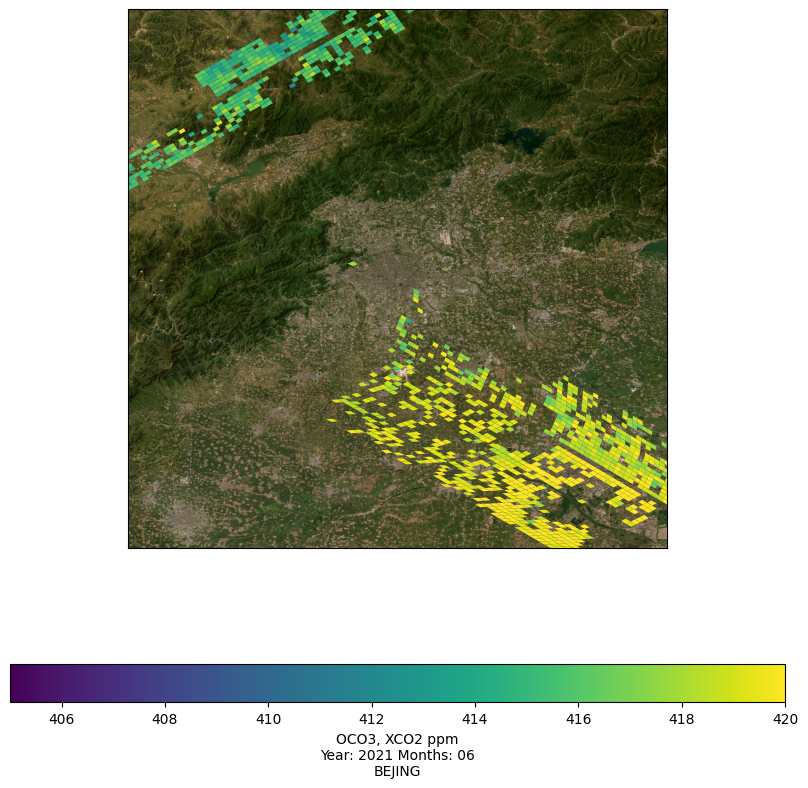

CPU times: user 11.1 s, sys: 199 ms, total: 11.3 s
Wall time: 26.2 s


In [ ]:
%%time
location= input("Enter the location: ")
geo_loc= Nominatim(user_agent="locate", timeout=4)

info= geo_loc.geocode(str(location)).raw

## get the Bounding box information
loc_bbx= info["boundingbox"]
bbx_list= [float(i) for i in loc_bbx]
print('\n************************************\n')
print("Bbox information of :\n"+f'{location}')
bbx_list

#########################################
## plot the location
## Input Data: total xco2 data, patches created from the data
plot_vertices(xco2_total, patches_total, bbx_list, location, year, month)

In [ ]:
# # plot the location
# plot_vertices(xco2_total, patches_total, bbx_list, location year, month)

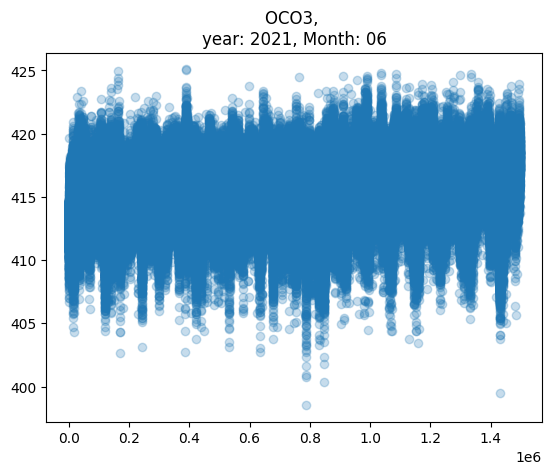

In [ ]:
plt.scatter(np.arange(0, len(xco2_total)), xco2_total, alpha= 0.25)
plt.title('OCO3, '+'\nyear: '+str(year) +', Month: '+ str(month));

## check memory usage

In [ ]:
import sys
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
                                           for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable\
    .sort_values(by='Size',ascending=False).head(10)
        
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size']\
    .apply(lambda x: obj_size_fmt(x))
    
    return memory_usage_by_variable

memory_usage()

,Size
flat_vertices,11.75MB
unpack_vertices,11.75MB
patches_total,11.75MB
xco2_total,5.84MB
files_oco2,5.99KB
list_files,5.99KB
html_links,5.35KB
Basemap,3.04KB
_i20,2.98KB
total_files,2.70KB


In [ ]:
d= memory_usage()
d.columns

Index(['Size'], dtype='object')